In [1]:
import os, os.path as op
import glob, shutil
import pandas as pd
import cProfile, pstats
import matplotlib.pyplot as plt
import seaborn as sns

%pdb off
%matplotlib inline 
# don't use %matplotlib notebook

Automatic pdb calling has been turned OFF


## Get Profiles

In [2]:
# get paths to profiles; realpath not guaranteed to work
path_wd    = op.dirname(op.realpath("__file__"))
path_profs = op.join(path_wd, 'Profiles')
print ('Profiles at:', path_profs)

Profiles at: /home/jovyan/ARIA-tools_git/tools/Profiling/Profiles


In [3]:
monyr    = '' # Optionally filter by a mon/yr, e.g., '0417'
length   = 'short' # use fewer or more products
profiles = glob.glob(op.join(path_profs, f'{monyr}*.profile'))

In [4]:
## make a dataframe with the total time info for all exps
rows = []
for prof in profiles:
    row = op.splitext(op.basename(prof))[0].split('_')[:5]
    p = pstats.Stats(prof)
    tt = p.get_stats_profile().total_tt
    row.append(tt)
    rows.append(row)
    
df_stats = pd.DataFrame(rows, columns='kind nprod gbranch monyr idx tot'.split()).set_index('idx')
df_stats.head(10)

,kind,nprod,gbranch,monyr,tot
idx,,,,,
2,VIRT,18,Profiling,0419,509.777
4,VIRT,21,Profiling,0419,687.686
1,VIRT,18,Profiling,0419,572.033
3,VIRT,21,Profiling,0419,695.299
1,PHYS,21,Profiling,0419,1440.714
1,VIRT,21,Profiling,0419,782.250
0,VIRT,18,Profiling,0419,1173.958
2,VIRT,21,Profiling,0419,726.661
0,VIRT,21,Profiling,0419,2379.085


In [5]:
## these arent really useful as its hard to find what's actually going on; use snakeviz or tuna to visualize
# p.sort_stats('time')
# p.strip_dirs().sort_stats('cumtime').print_stats()

## Single Frame

In [6]:
nprod = 18 if length == 'short' else 80
df_sf = df_stats[df_stats.nprod == str(nprod)]
df_sf

,kind,nprod,gbranch,monyr,tot
idx,,,,,
2,VIRT,18,Profiling,0419,509.777
1,VIRT,18,Profiling,0419,572.033
0,VIRT,18,Profiling,0419,1173.958
0,PHYS,18,Profiling,0419,246.391
1,PHYS,18,Profiling,0419,245.150
3,VIRT,18,Profiling,0419,513.461
4,VIRT,18,Profiling,0419,487.941


### Virtual vs Physical, one branch

In [7]:
gbranch = 'Profiling'

In [8]:
df_sf_b = df_sf[df_sf.gbranch==gbranch]

In [26]:
df_sf_b['lbl']   = df_sf_b.apply(lambda x: f"{x['kind']}{x.name}", axis=1)
col_dct          = {'VIRT': 'blue', 'PHYS':'gray'}
df_sf_b['color'] =  df_sf_b['kind'].apply(lambda x: col_dct[x])

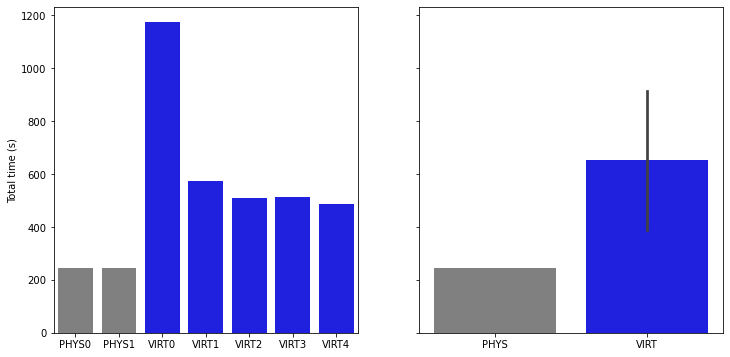

In [27]:
df_sf_b.sort_values('lbl', inplace=True)

fig, axes = plt.subplots(figsize=(12, 6), ncols=2, sharey=True)
# plot all the experiments
axe0 = sns.barplot(x='lbl', y='tot', palette=df_sf_b['color'], data=df_sf_b, ax=axes[0])
axe0.set_xlabel('')
axe0.set_ylabel('Total time (s)')

# plot the average
axe1 = sns.barplot(x='kind', y='tot', palette=df_sf_b['color'].unique(), ci='sd', data=df_sf_b, ax=axes[1])
axe1.set_xlabel(''); axe1.set_ylabel('');

In [11]:
mu, sig = df_sf.groupby('kind').mean(), df_sf.groupby('kind').std()
print (f"Physical: {mu.loc['PHYS'].item():.2f} +/- {sig.loc['PHYS'].item():.2f} seconds")
print (f"Virtual: {mu.loc['VIRT'].item():.2f} +/- {sig.loc['VIRT'].item():.2f} seconds")

Physical: 245.77 +/- 0.88 seconds
Virtual: 651.43 +/- 293.76 seconds


### Virtual vs Physical, all branches

In [12]:
# dummy to check plotting
df_sf1 = df_sf.copy()
df_sf1['gbranch'] = 'dev'
df_sf1['tot'] += 100
df_sf  = pd.concat([df_sf, df_sf1])

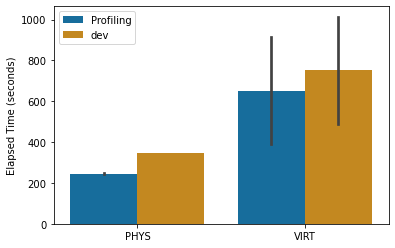

In [29]:
ax = sns.barplot(x='kind', y='tot', data=df_sf.sort_values('kind'), ci='sd', palette='colorblind', hue='gbranch')
ax.set_xlabel('')
ax.set_ylabel('Elapsed Time (seconds)')
ax.legend().set_title('')

In [14]:
mu, sig = df_sf.groupby('kind gbranch'.split()).mean().reset_index(), df_sf.groupby('kind gbranch'.split()).std().reset_index()
for gb in mu['gbranch'].unique():
    mu0, sig0 = mu[mu.gbranch == gb].set_index('kind'), sig[sig.gbranch==gb].set_index('kind')
    print (f"Physical {gb}: {mu0.loc['PHYS', 'tot'].item():.2f} +/- {sig0.loc['PHYS', 'tot'].item():.2f} seconds")
    print (f"Virtual {gb}: {mu0.loc['VIRT', 'tot'].item():.2f} +/- {sig0.loc['VIRT', 'tot'].item():.2f} seconds")
    print ('')

Physical Profiling: 245.77 +/- 0.88 seconds
Virtual Profiling: 651.43 +/- 293.76 seconds

Physical dev: 345.77 +/- 0.88 seconds
Virtual dev: 751.43 +/- 293.76 seconds



## Multiple Frames

In [16]:
nprod_tr = 21 if length == 'short' else 83
df_mf = df_stats[df_stats.nprod == str(nprod_tr)]
df_mf

,kind,nprod,gbranch,monyr,tot
idx,,,,,
4,VIRT,21,Profiling,0419,687.686
3,VIRT,21,Profiling,0419,695.299
1,PHYS,21,Profiling,0419,1440.714
1,VIRT,21,Profiling,0419,782.250
2,VIRT,21,Profiling,0419,726.661
0,VIRT,21,Profiling,0419,2379.085
0,PHYS,21,Profiling,0419,1437.171


### Virtual vs Physical, one branch

In [17]:
gbranch = 'Profiling'

In [18]:
df_mf_b = df_mf[df_mf.gbranch==gbranch]

In [24]:
df_mf_b['lbl']   = df_mf_b.apply(lambda x: f"{x['kind']}{x.name}", axis=1)
col_dct          = {'VIRT': 'darkblue', 'PHYS':'dimgray'}
df_mf_b['color'] =  df_mf_b['kind'].apply(lambda x: col_dct[x])

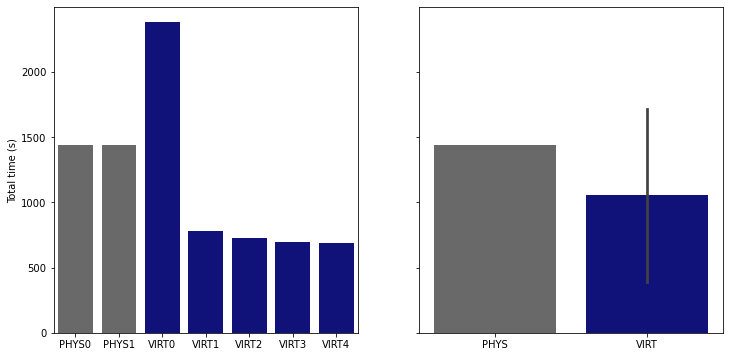

In [25]:
df_mf_b.sort_values('lbl', inplace=True)

fig, axes = plt.subplots(figsize=(12, 6), ncols=2, sharey=True)
# plot all the experiments
axe0 = sns.barplot(x='lbl', y='tot', palette=df_mf_b['color'], data=df_mf_b, ax=axes[0])
axe0.set_xlabel('')
axe0.set_ylabel('Total time (s)')

# plot the average
axe1 = sns.barplot(x='kind', y='tot', palette=df_mf_b['color'].unique(), ci='sd', data=df_mf_b, ax=axes[1])
axe1.set_xlabel(''); axe1.set_ylabel('');

In [21]:
mu, sig = df_mf.groupby('kind').mean(), df_mf.groupby('kind').std()
print (f"Physical: {mu.loc['PHYS'].item():.2f} +/- {sig.loc['PHYS'].item():.2f} seconds")
print (f"Virtual: {mu.loc['VIRT'].item():.2f} +/- {sig.loc['VIRT'].item():.2f} seconds")

Physical: 1438.94 +/- 2.51 seconds
Virtual: 1054.20 +/- 741.57 seconds


### Virtual vs Physical, all branches

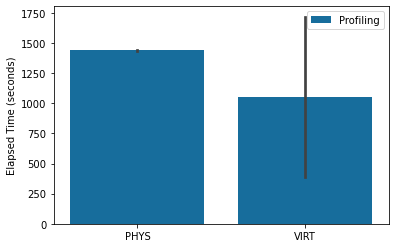

In [28]:
ax = sns.barplot(x='kind', y='tot', ci='sd', data=df_mf.sort_values('kind'), palette='colorblind', hue='gbranch')
ax.set_xlabel('')
ax.set_ylabel('Elapsed Time (seconds)')
ax.legend().set_title('')

In [23]:
mu, sig = df_mf.groupby('kind gbranch'.split()).mean().reset_index(), df_mf.groupby('kind gbranch'.split()).std().reset_index()
for gb in mu['gbranch'].unique():
    mu0, sig0 = mu[mu.gbranch == gb].set_index('kind'), sig[sig.gbranch==gb].set_index('kind')
    print (f"Physical {gb}: {mu0.loc['PHYS', 'tot'].item():.2f} +/- {sig0.loc['PHYS', 'tot'].item():.2f} seconds")
    print (f"Virtual {gb}: {mu0.loc['VIRT', 'tot'].item():.2f} +/- {sig0.loc['VIRT', 'tot'].item():.2f} seconds")
    print ('')

Physical Profiling: 1438.94 +/- 2.51 seconds
Virtual Profiling: 1054.20 +/- 741.57 seconds

